In [1]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data as mdmask
import ingest_tif_stack as ingest

In [2]:
import registerer_copy as reg
import preprocessor_copy as pre
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
atlas = ndreg.imgRead('./atlas/ara_atlas.img')
atlas_width, atlas_height, atlas_depth = atlas.GetSize()

In [4]:
full_img = ndreg.imgRead('./missing_insula/whole_insula.img')
# Reorient image to be same orientation as atlas
orientation_atlas = 'pir'
orientation_image = 'lps'
full_img = ndreg.imgReorient(full_img, orientation_image, orientation_atlas)
img_width, img_height, img_depth = full_img.GetSize()

# Rigid experiments

1. Try increasing missing data amount until rigid doesn't work
2. Try composing translation then rotation transforms
3. Look into the versor transform, registration method functions
 * http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/22_Transforms.html
4. Try take out the physical optimizer
5. Look at the transformation computed

In [15]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual,FloatSlider
import ipywidgets as widgets

def atlas_rigid_slider(x, res):
    plt.clf()
    atlas_rigid, final_transform, img = res[x]
    ndreg.imgShow(atlas_rigid)
    return

def mse_plot_slider(x, res):
    plt.clf()
    atlas_rigid, final_transform, img = res[x]
    mask_dilation_radius = 10 # voxels
    mask_bc = sitk.BinaryDilate(pre.create_mask(img, use_triangle=True), mask_dilation_radius)
    atlas_rigid_slice = sitk.GetArrayFromImage(sitk.Normalize(atlas_rigid))[:,50,:]
    img_rigid_slice = sitk.GetArrayFromImage(sitk.Normalize(img))[:,50,:]
    side_img_slice = sitk.GetArrayFromImage(mask_bc)[:,50,:]
    mdmask.plot_mse(atlas_rigid_slice, img_rigid_slice, side_img=side_img_slice, color_blend=True)
    return

def missing_img_slider(x, res):
    plt.clf()
    atlas_rigid, final_transform, img = res[x]
    ndreg.imgShow(img, vmax=2500)
    return

## Anterior missing

In [16]:
starting_percent = 0.0; ending_percent = 0.40; increment_factor = 20
missing_percentages = np.round(np.linspace(starting_percent, ending_percent, 
                                           num=int(increment_factor*(ending_percent-starting_percent))+1), 2)
missing_dim = 2
ant_percent_results = {}
print("Missing percentages: {}".format(list(missing_percentages)))

Missing percentages: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]


Percentage of image mssing: 0.0


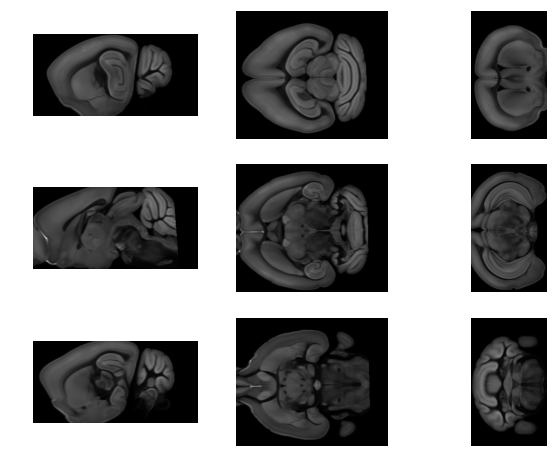

Percentage of image mssing: 0.05


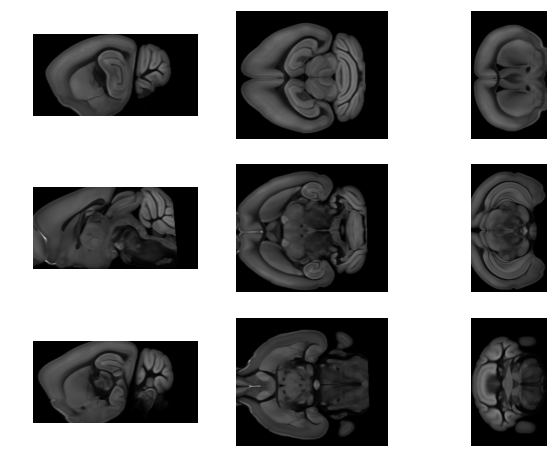

Percentage of image mssing: 0.1


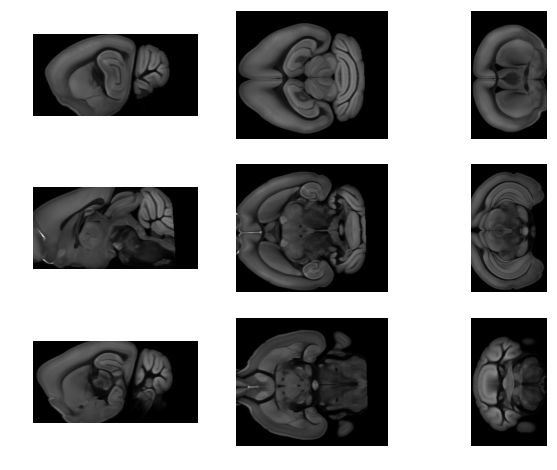

Percentage of image mssing: 0.15


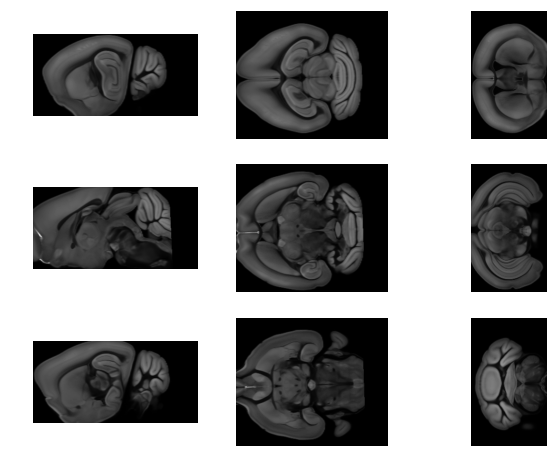

Percentage of image mssing: 0.2


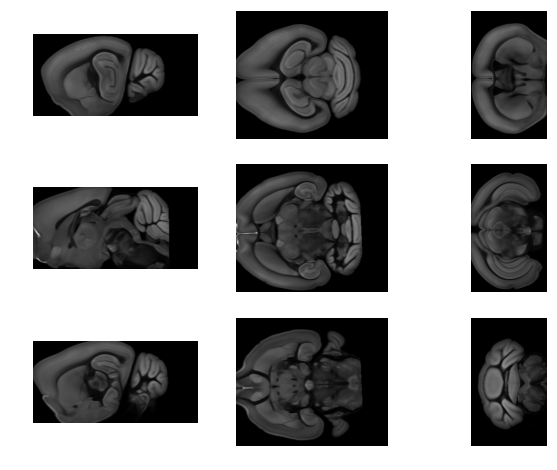

Percentage of image mssing: 0.25


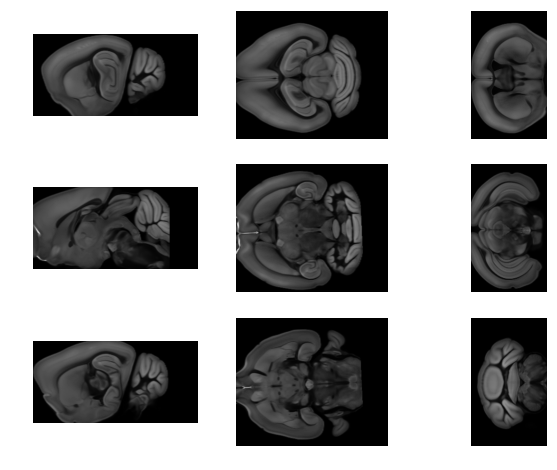

Percentage of image mssing: 0.3


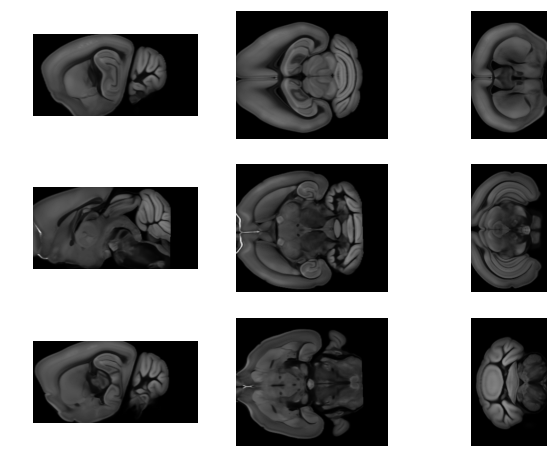

Percentage of image mssing: 0.35


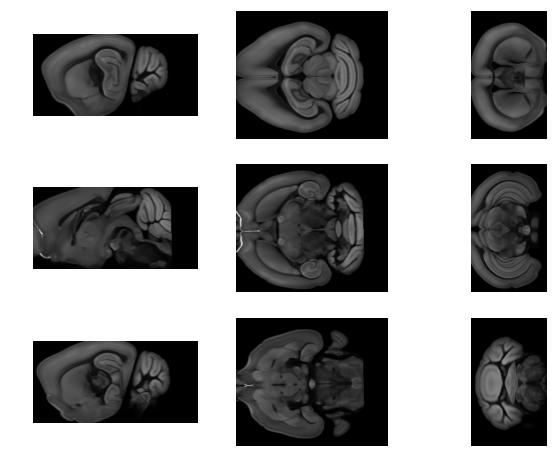

Percentage of image mssing: 0.4


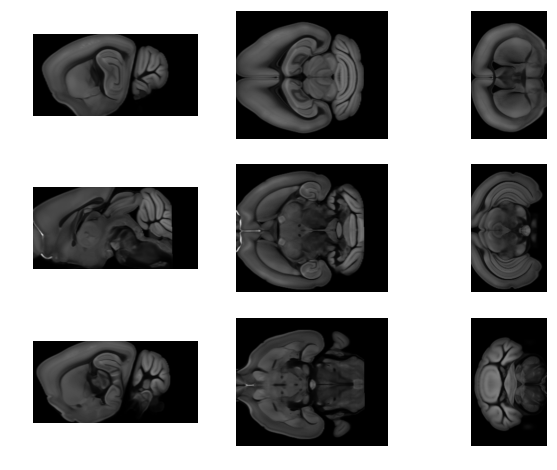

In [17]:
for p in missing_percentages:
    
    # Create the missing image
    missing_array = mdmask.gen_frac_mask(img_depth, img_height, img_width, p, missing_dim, side='right')
    missing_mask = mdmask.convert_to_image(missing_array.astype('uint16'))
    missing_mask.CopyInformation(full_img)
    missing_img = mdmask.mask_img(full_img, missing_mask)
    
    img = missing_img
    
    # Bias correction
    mask_dilation_radius = 10 # voxels
    mask_bc = sitk.BinaryDilate(pre.create_mask(img, use_triangle=True), mask_dilation_radius)
    img_bc, bias = pre.correct_bias_field(img, scale=0.25, spline_order=4, mask=mask_bc,
                                         num_control_pts=[5,5,5],
                                         niters=[50, 50, 50, 50])
    atlas_n = sitk.Normalize(atlas)
    img_bc_n = sitk.Normalize(img_bc)
    
    # Compute rigid transform
    final_transform = reg.register_rigid(atlas_n,
                                        img_bc_n,
                                        fixed_mask=missing_mask,
                                        learning_rate=1e-1,
                                        grad_tol=4e-6,
                                        use_mi=False,
                                        iters=50,
                                        shrink_factors=[4,2,1],
                                        sigmas=[0.4, 0.2, 0.1],
                                        verbose=False)
    
    # Perform the rigid transform
    atlas_rigid = reg.resample(atlas, final_transform, img_bc, default_value=ndreg.imgPercentile(atlas,0.01))
    
    print("Percentage of image mssing: {}".format(p))
    ndreg.imgShow(atlas_rigid)
    ant_percent_results[p] = (atlas_rigid, final_transform, img)

In [18]:
interact(mse_plot_slider, 
         res=fixed(ant_percent_results),
         x=FloatSlider(min=starting_percent, max=ending_percent+0.0001, step=1/float(increment_factor), continuous_update=True))


interactive(children=(FloatSlider(value=0.0, description=u'x', max=0.4001, step=0.05), Output()), _dom_classes=('widget-interact',))

<function __main__.mse_plot_slider>

In [19]:
interact(atlas_rigid_slider, 
         res=fixed(ant_percent_results),
         x=FloatSlider(min=starting_percent, max=ending_percent+0.0001, step=1/float(increment_factor), continuous_update=True))


interactive(children=(FloatSlider(value=0.0, description=u'x', max=0.4001, step=0.05), Output()), _dom_classes=('widget-interact',))

<function __main__.atlas_rigid_slider>

In [20]:
interact(missing_img_slider, 
         res=fixed(ant_percent_results),
         x=FloatSlider(min=starting_percent, max=ending_percent+0.0001, step=1/float(increment_factor), continuous_update=True))


interactive(children=(FloatSlider(value=0.0, description=u'x', max=0.4001, step=0.05), Output()), _dom_classes=('widget-interact',))

<function __main__.missing_img_slider>

## Hemisphere missing

In [21]:
starting_percent = 0.0; ending_percent = 0.40; increment_factor = 20
missing_percentages = np.round(np.linspace(starting_percent, ending_percent, 
                                           num=int(increment_factor*(ending_percent-starting_percent))+1), 2)
missing_dim = 0
hemi_percent_results = {}
print("Missing percentages: {}".format(list(missing_percentages)))

Missing percentages: [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]


Percentage of image mssing: 0.0


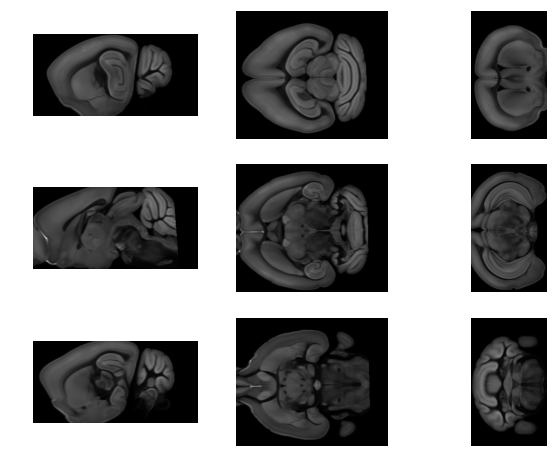

Percentage of image mssing: 0.05


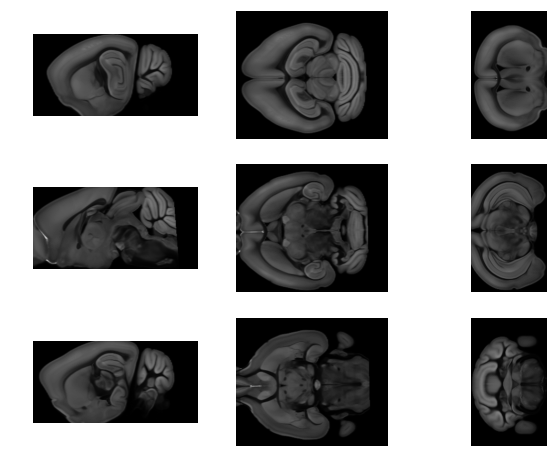

Percentage of image mssing: 0.1


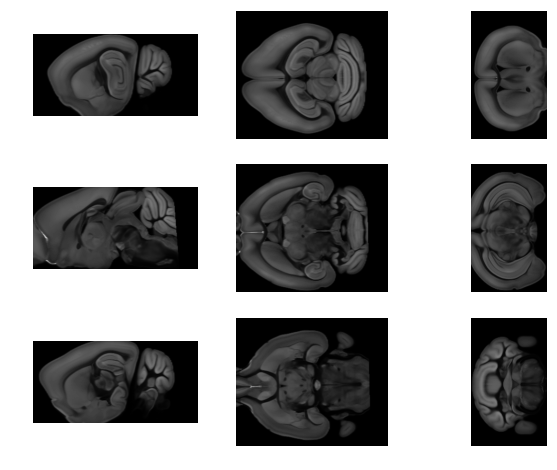

Percentage of image mssing: 0.15


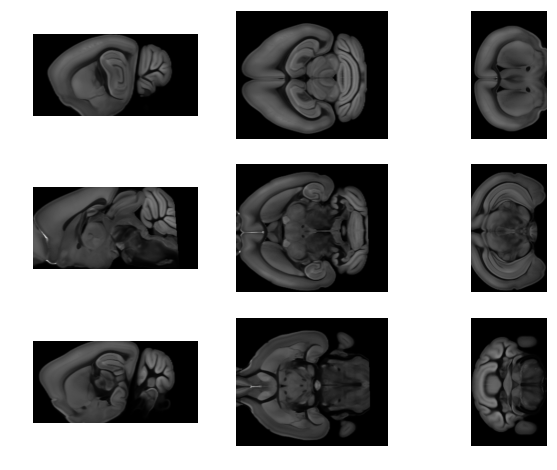

Percentage of image mssing: 0.2


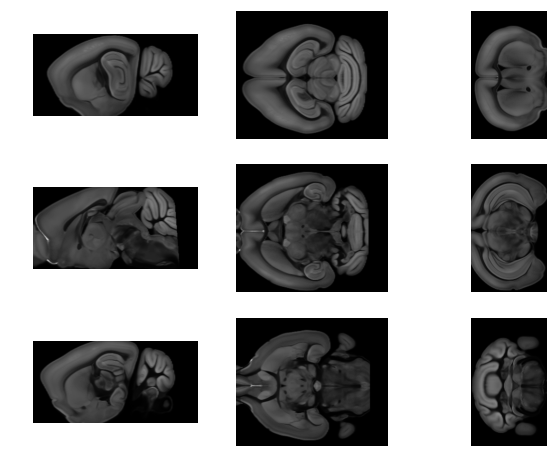

Percentage of image mssing: 0.25


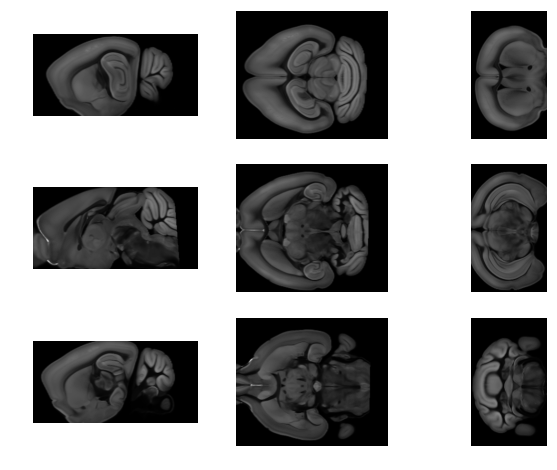

Percentage of image mssing: 0.3


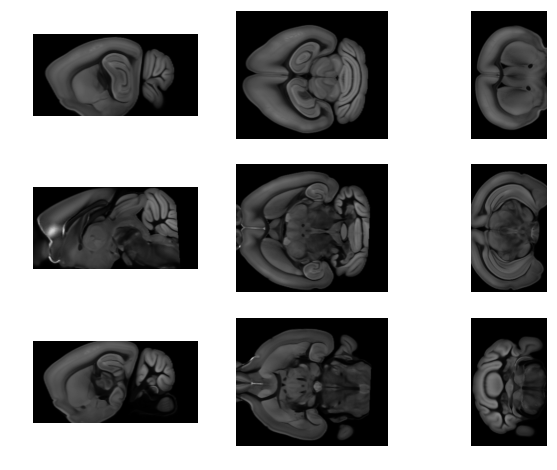

Percentage of image mssing: 0.35


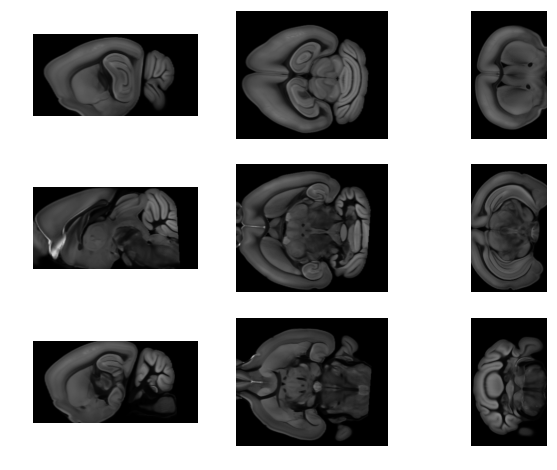

Percentage of image mssing: 0.4


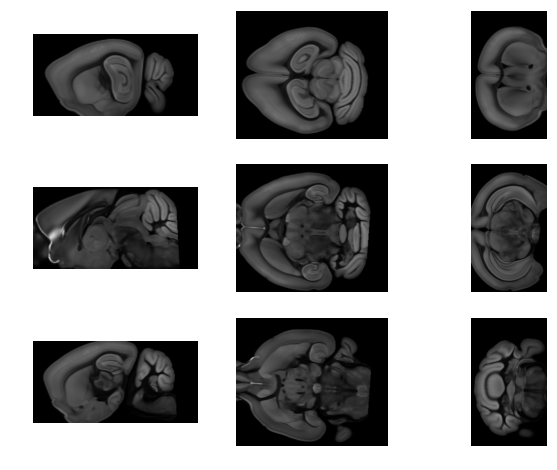

In [22]:
for p in missing_percentages:
    
    # Create the missing image
    missing_array = mdmask.gen_frac_mask(img_depth, img_height, img_width, p, missing_dim, side='right')
    missing_mask = mdmask.convert_to_image(missing_array.astype('uint16'))
    missing_mask.CopyInformation(full_img)
    missing_img = mdmask.mask_img(full_img, missing_mask)
    
    img = missing_img
    
    # Bias correction
    mask_dilation_radius = 10 # voxels
    mask_bc = sitk.BinaryDilate(pre.create_mask(img, use_triangle=True), mask_dilation_radius)
    img_bc, bias = pre.correct_bias_field(img, scale=0.25, spline_order=4, mask=mask_bc,
                                         num_control_pts=[5,5,5],
                                         niters=[50, 50, 50, 50])
    atlas_n = sitk.Normalize(atlas)
    img_bc_n = sitk.Normalize(img_bc)
    
    # Compute rigid transform
    final_transform = reg.register_rigid(atlas_n,
                                        img_bc_n,
                                        fixed_mask=missing_mask,
                                        learning_rate=1e-1,
                                        grad_tol=4e-6,
                                        use_mi=False,
                                        iters=50,
                                        shrink_factors=[4,2,1],
                                        sigmas=[0.4, 0.2, 0.1],
                                        verbose=False)
    
    # Perform the rigid transform
    atlas_rigid = reg.resample(atlas, final_transform, img_bc, default_value=ndreg.imgPercentile(atlas,0.01))
    
    # Display the MSE plot
#     atlas_rigid_slice = sitk.GetArrayFromImage(sitk.Normalize(atlas_rigid))[:,50,:]
#     img_rigid_slice = sitk.GetArrayFromImage(sitk.Normalize(img))[:,50,:]
#     side_img_slice = sitk.GetArrayFromImage(mask_bc)[:,50,:]
#     mdmask.plot_mse(atlas_rigid_slice, img_rigid_slice, side_img=side_img_slice, color_blend=True)
    
    print("Percentage of image mssing: {}".format(p))
    ndreg.imgShow(atlas_rigid)
    hemi_percent_results[p] = (atlas_rigid, final_transform, img)

In [23]:
interact(mse_plot_slider, 
         res=fixed(hemi_percent_results),
         x=FloatSlider(min=starting_percent, max=ending_percent+0.0001, step=1/float(increment_factor), continuous_update=True))


interactive(children=(FloatSlider(value=0.0, description=u'x', max=0.4001, step=0.05), Output()), _dom_classes=('widget-interact',))

<function __main__.mse_plot_slider>

In [24]:
interact(atlas_rigid_slider, 
         res=fixed(hemi_percent_results),
         x=FloatSlider(min=starting_percent, max=ending_percent+0.0001, step=1/float(increment_factor), continuous_update=True))


interactive(children=(FloatSlider(value=0.0, description=u'x', max=0.4001, step=0.05), Output()), _dom_classes=('widget-interact',))

<function __main__.atlas_rigid_slider>

In [25]:
interact(missing_img_slider, 
         res=fixed(hemi_percent_results),
         x=FloatSlider(min=starting_percent, max=ending_percent+0.0001, step=1/float(increment_factor), continuous_update=True))


interactive(children=(FloatSlider(value=0.0, description=u'x', max=0.4001, step=0.05), Output()), _dom_classes=('widget-interact',))

<function __main__.missing_img_slider>